<a href="https://colab.research.google.com/github/AmirHoseein99/Movie_Recommendation_system/blob/master/Movie_Recommender_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [ ]:
! unzip "/content/drive/MyDrive/lense_movie.zip"

In [3]:
movies = pd.read_csv("/content/movies.csv")
tags = pd.read_csv("/content/tags.csv")
ratings = pd.read_csv("/content/ratings.csv")
links = pd.read_csv("/content/links.csv")

In [4]:
movies = pd.read_csv("/content/movies.csv", index_col="movieId")
print(movies.shape)
movies.head()

(9742, 2)


,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [5]:
movies["genres"] = movies["genres"].apply(lambda x : x.split("|"))
movies["genres"] = movies["genres"].apply(lambda x : ' '.join(word for word in x))
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
2,Jumanji (1995),Adventure Children Fantasy
3,Grumpier Old Men (1995),Comedy Romance
4,Waiting to Exhale (1995),Comedy Drama Romance
5,Father of the Bride Part II (1995),Comedy


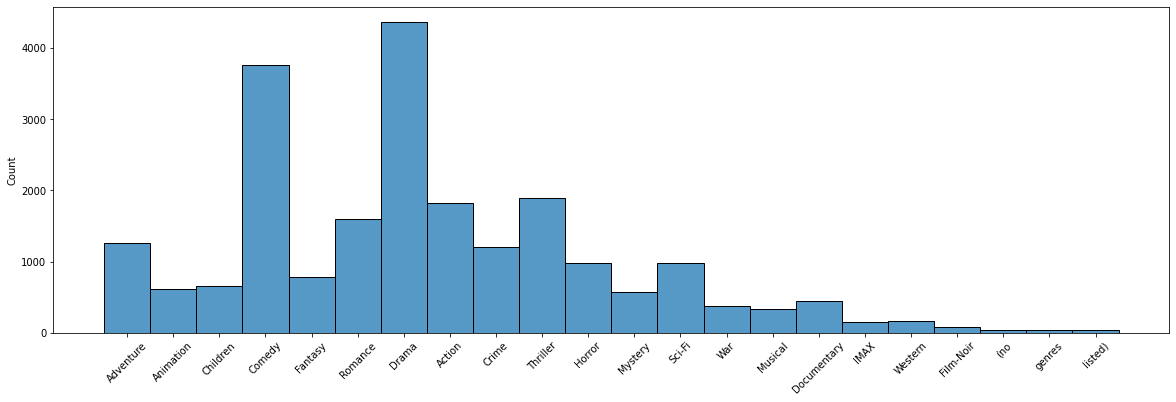

In [6]:
all_genres = [genre for all_genre in movies.genres.to_numpy() for genre in all_genre.split(" ")]
plt.figure(figsize=(20, 6))
_ = sns.histplot(data=all_genres)
_ = plt.xticks(rotation=45)

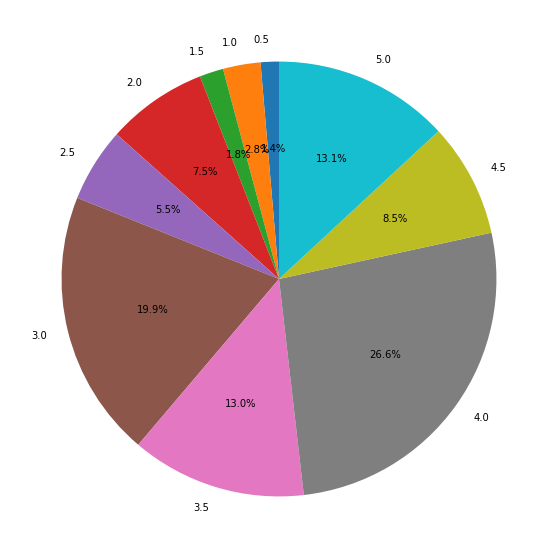

In [58]:
all_rates, counts = np.unique(ratings.rating.to_numpy(), return_counts = True)
plt.figure(figsize=(10, 10))
_=plt.pie(counts, labels=all_rates, autopct='%1.1f%%', startangle=90)

# Content Based
recommend Movise Based on similare genres

In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9742 entries, 1 to 193609
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   9742 non-null   object
 1   genres  9742 non-null   object
dtypes: object(2)
memory usage: 228.3+ KB


In [15]:
similarity_feature = movies["genres"].to_numpy()
similarity_feature = np.array([genre.lower() for genre in similarity_feature])
similarity_feature[0]

'adventure animation children comedy fantasy'

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
count_vecotr = CountVectorizer()
count_vecotr.fit(similarity_feature)
similarity_feature = count_vecotr.transform(similarity_feature)

# Using Cosine Similarity

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
movies_similarity = cosine_similarity(similarity_feature)
movies_similarity = pd.DataFrame(movies_similarity)
print(movies_similarity.shape)
movies_similarity.head()

(9742, 9742)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9702,9703,9704,9705,9706,9707,9708,9709,9710,9711,9712,9713,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723,9724,9725,9726,9727,9728,9729,9730,9731,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
0,1.000000,0.774597,0.316228,0.258199,0.447214,0.0,0.316228,0.632456,0.0,0.258199,0.258199,0.316228,0.774597,0.00000,0.258199,0.000000,0.000000,0.447214,0.447214,0.200000,0.258199,0.000000,0.0,0.000000,0.000000,0.00000,0.316228,0.000000,0.365148,0.000000,0.00000,0.0,0.316228,0.000000,0.632456,0.316228,0.00000,0.000000,0.000000,0.00000,...,0.0,0.316228,0.447214,0.223607,0.223607,0.182574,0.67082,0.223607,0.400000,0.0,0.447214,0.547723,0.000000,0.316228,0.447214,0.774597,0.316228,0.0,0.258199,0.0,0.0,0.258199,0.0,0.000000,0.447214,0.00000,0.00000,0.447214,0.0,0.400000,0.400000,0.316228,0.316228,0.447214,0.0,0.670820,0.774597,0.00000,0.316228,0.447214
1,0.774597,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.816497,0.0,0.333333,0.000000,0.000000,0.666667,0.00000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.408248,0.000000,0.471405,0.000000,0.00000,0.0,0.408248,0.000000,0.408248,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.288675,0.288675,0.235702,0.57735,0.000000,0.516398,0.0,0.288675,0.471405,0.000000,0.000000,0.000000,0.666667,0.000000,0.0,0.333333,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.258199,0.000000,0.000000,0.000000,0.000000,0.0,0.288675,0.333333,0.00000,0.000000,0.000000
2,0.316228,0.000000,1.000000,0.816497,0.707107,0.0,1.000000,0.000000,0.0,0.000000,0.816497,0.500000,0.000000,0.00000,0.408248,0.000000,0.500000,0.707107,0.707107,0.316228,0.408248,0.000000,0.0,0.000000,0.500000,0.00000,0.000000,0.500000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.500000,1.000000,0.00000,0.000000,0.000000,0.00000,...,0.0,0.500000,0.707107,0.000000,0.000000,0.000000,0.00000,0.353553,0.000000,0.0,0.353553,0.288675,0.000000,1.000000,0.707107,0.408248,0.500000,0.0,0.000000,0.0,0.0,0.408248,0.0,0.500000,0.707107,0.00000,0.00000,0.000000,0.0,0.316228,0.316228,0.000000,0.500000,0.000000,0.0,0.353553,0.408248,0.00000,0.000000,0.707107
3,0.258199,0.000000,0.816497,1.000000,0.577350,0.0,0.816497,0.000000,0.0,0.000000,1.000000,0.408248,0.000000,0.57735,0.333333,0.408248,0.816497,0.577350,0.577350,0.516398,0.333333,0.258199,0.0,0.333333,0.816497,0.57735,0.408248,0.816497,0.235702,0.408248,0.57735,0.0,0.408248,0.408248,0.408248,0.816497,0.57735,0.408248,0.333333,0.57735,...,0.0,0.408248,0.577350,0.000000,0.000000,0.235702,0.00000,0.288675,0.000000,0.0,0.288675,0.235702,0.408248,0.816497,0.577350,0.333333,0.816497,0.0,0.000000,0.0,0.0,0.666667,0.0,0.816497,0.577350,0.57735,0.57735,0.000000,0.0,0.258199,0.258199,0.408248,0.816497,0.000000,0.0,0.288675,0.333333,0.57735,0.000000,0.577350
4,0.447214,0.000000,0.707107,0.577350,1.000000,0.0,0.707107,0.000000,0.0,0.000000,0.577350,0.707107,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000,0.447214,0.577350,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.707107,0.707107,0.00000,0.000000,0.000000,0.00000,...,0.0,0.707107,1.000000,0.000000,0.000000,0.000000,0.00000,0.500000,0.000000,0.0,0.500000,0.408248,0.000000,0.707107,1.000000,0.577350,0.707107,0.0,0.000000,0.0,0.0,0.577350,0.0,0.000000,1.000000,0.00000,0.00000,0.000000,0.0,0.447214,0.447214,0.000000,0.707107,0.000000,0.0,0.500000,0.577350,0.00000,0.000000,1.000000


# Get Top 10 most similar movies

In [55]:
def get_similar_movies_content(movie_name):
  movie_id = movies[movies.title == f"{movie_name}"].index[0]
  all_moveis = movies_similarity[movie_id - 1]

  k = 10
  idx = np.argpartition(all_moveis, -k)
  most_similar_movies_id = idx[-10:].values
  most_similar_movies_id = np.delete(most_similar_movies_id, np.where(most_similar_movies_id == movie_id - 1)[0])

  for movie_id in most_similar_movies_id :
    print(movies.iloc[movie_id].title)


In [57]:
get_similar_movies_content("Toy Story (1995)")

Wild, The (2006)
The Good Dinosaur (2015)
Adventures of Rocky and Bullwinkle, The (2000)
Moana (2016)
Turbo (2013)
Antz (1998)
Monsters, Inc. (2001)
Tale of Despereaux, The (2008)
Shrek the Third (2007)


# Collaborative filtering recommender systems

In [60]:
print(ratings.shape)
ratings.head()

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Number of Votes for each User

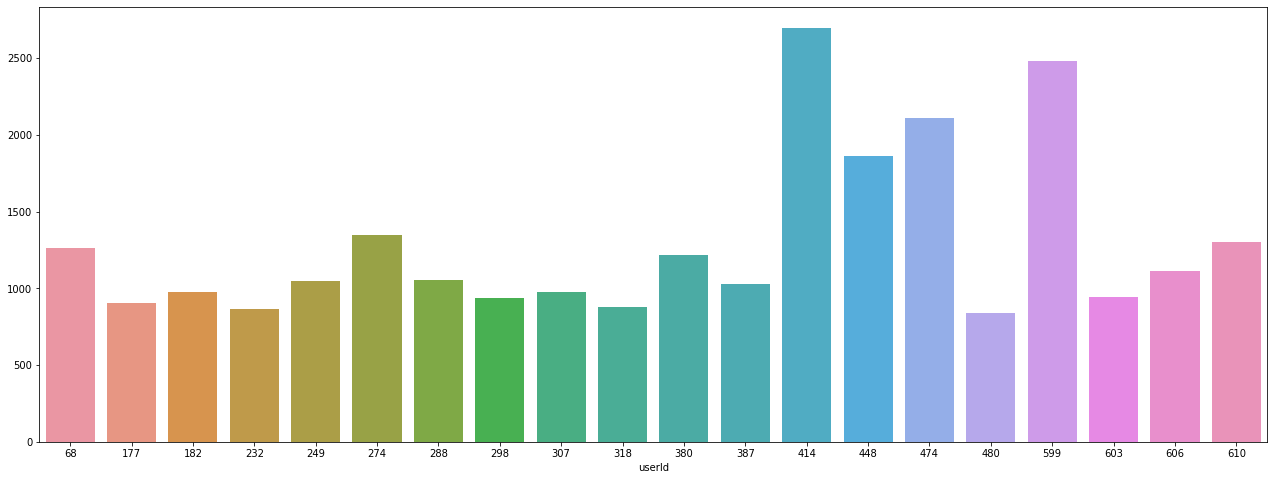

In [92]:
user_vote = pd.DataFrame(ratings.groupby("userId")["rating"].agg("count"))
top_users_index = user_vote.rating.sort_values(ascending=False)[:20].index
top_users_value = user_vote.rating.sort_values(ascending=False)[:20].values
plt.figure(figsize=(22, 8))
_ = sns.barplot(x=top_users_index, y=top_users_value)

In [116]:
user_vote.describe()

,rating
count,610.000000
mean,165.304918
std,269.480584
min,20.000000
25%,35.000000
50%,70.500000
75%,168.000000
max,2698.000000


# Number of Votes for each movie

In [112]:
def get_movie_name(movie_id):
  return movies.iloc[movie_id].title

['Age of Innocence, The (1993)', 'I Love Trouble (1994)', 'Virtuosity (1995)', 'Cemetery Man (Dellamorte Dellamore) (1994)', 'Teenage Mutant Ninja Turtles II: The Secret of the Ooze (1991)', 'Quiz Show (1994)', 'Terminal Velocity (1994)', "Jupiter's Wife (1994)", 'Last Dance (1996)', 'Aristocats, The (1970)', 'Billy Elliot (2000)', 'Jumanji (1995)', 'Picture Perfect (1997)', 'Georgia (1995)', 'Autumn in New York (2000)', 'Mighty Aphrodite (1995)', 'Cinderella (1950)', 'Love & Human Remains (1993)', 'Career Girls (1997)', 'Animal Crackers (1930)']


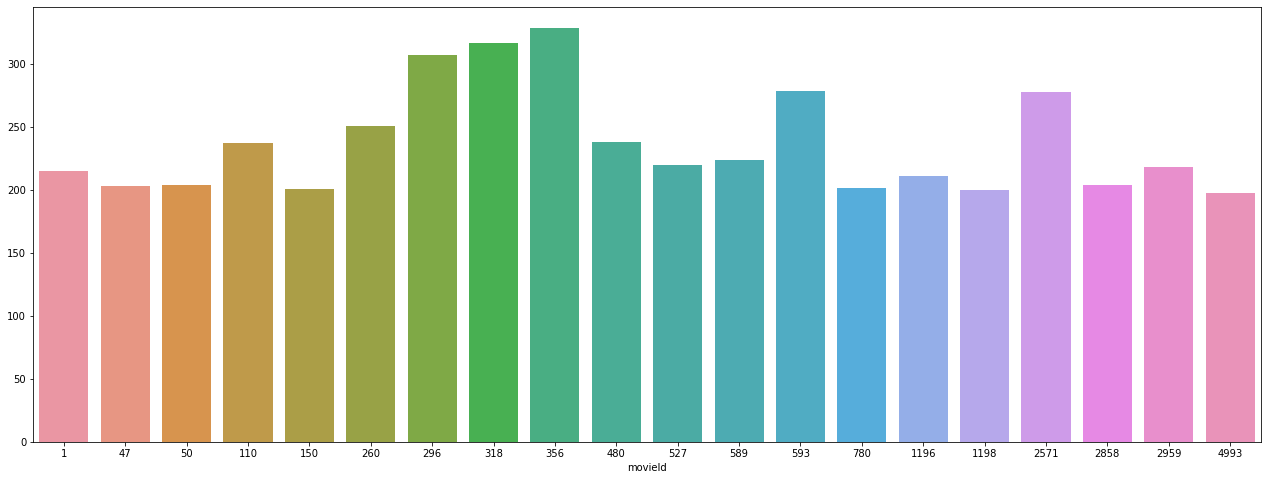

In [113]:
movies_votes = pd.DataFrame(ratings.groupby("movieId")["rating"].agg("count"))
top_movies_index = movies_votes.rating.sort_values(ascending=False)[:20].index
top_movies_value = movies_votes.rating.sort_values(ascending=False)[:20].values
movie_names = [get_movie_name(id) for id in top_movies_index]
plt.figure(figsize=(22, 8))
_ = sns.barplot(x=top_movies_index, y=top_movies_value)
print(movie_names)

In [115]:
movies_votes.describe()

,rating
count,9724.000000
mean,10.369807
std,22.401005
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,329.000000


# Putting users and movie in one pivot table for collaborative filtering

In [204]:
data = pd.pivot(index = 'movieId',columns = 'userId', data = ratings, values ='rating')
print(data.shape)
data.head()

(9724, 610)


userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,4.5,3.5,4.0,NaN,3.5,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,5.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,3.0,2.5,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,2.5,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,2.5,4.0,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning

### Getting rid of movies with less than Ten(10) Votes

In [205]:
data = data.dropna(thresh=10)
print(data.shape)
data.head()

(2269, 610)


userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,4.5,3.5,4.0,NaN,3.5,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,5.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,3.0,2.5,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,2.5,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,2.5,4.0,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,4.5,NaN,NaN,NaN,3.5,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.5,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,3.5,NaN,3.0,NaN,NaN,NaN,NaN,3.0,NaN,4.5,NaN,NaN,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,5.0


### Getting rid of users with less than hundred and seventy(170) Votes

In [206]:
data = data.dropna(axis = 1, thresh=170)
print(data.shape)
data.head()

(2269, 138)


userId,1,4,6,18,19,20,21,28,41,42,45,50,51,57,62,63,64,66,68,73,82,84,89,91,103,104,105,111,119,122,125,132,135,139,140,156,160,166,169,177,...,438,448,452,453,462,469,474,477,480,483,484,489,495,509,514,517,520,522,525,534,552,555,560,561,562,567,570,573,580,586,590,596,597,599,600,603,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,3.5,4.0,NaN,3.5,NaN,NaN,NaN,4.0,3.0,NaN,5.0,NaN,5.0,4.0,4.0,2.5,4.5,2.5,NaN,3.0,4.0,4.0,NaN,NaN,NaN,3.5,NaN,NaN,2.0,4.0,NaN,3.0,4.0,4.0,5.0,4.5,5.0,...,4.5,5.0,NaN,5.0,1.5,4.0,4.0,4.0,3.0,4.0,4.5,NaN,NaN,4.0,4.0,4.0,NaN,3.0,4.0,4.0,NaN,4.0,3.0,4.0,4.5,3.5,4.0,5.0,3.0,NaN,4.0,4.0,4.0,3.0,2.5,4.0,2.5,4.0,2.5,5.0
2,NaN,NaN,4.0,3.0,3.0,3.0,3.5,NaN,NaN,NaN,NaN,NaN,4.5,NaN,4.0,NaN,NaN,NaN,2.5,NaN,3.0,NaN,NaN,3.0,4.0,3.0,NaN,NaN,NaN,4.0,4.0,NaN,3.0,NaN,3.5,NaN,4.0,NaN,4.0,3.5,...,NaN,3.0,NaN,NaN,NaN,NaN,3.0,4.0,3.0,4.0,2.5,2.5,NaN,NaN,NaN,3.0,NaN,NaN,3.5,4.5,NaN,NaN,NaN,4.0,NaN,NaN,3.5,4.5,NaN,4.0,2.5,NaN,NaN,2.5,4.0,NaN,NaN,NaN,2.0,NaN
3,4.0,NaN,5.0,NaN,3.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,3.5,NaN,2.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,3.0,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,1.5,NaN,NaN,NaN,NaN,2.0,NaN
5,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,NaN,NaN,3.0,NaN,NaN,4.0,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,1.5,NaN,NaN,2.5,NaN,2.0,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,4.0,4.0,NaN,NaN,NaN,3.5,NaN,NaN,4.0,NaN,NaN,3.0,4.5,NaN,4.5,NaN,4.0,NaN,3.5,4.0,NaN,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,2.0,3.5,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,3.0,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.5,4.0,NaN,3.5,NaN,3.0,4.5,NaN,4.0,NaN,NaN,NaN,5.0


### Filling NaN Values

In [207]:
data = data.fillna(0)
data.head()

userId,1,4,6,18,19,20,21,28,41,42,45,50,51,57,62,63,64,66,68,73,82,84,89,91,103,104,105,111,119,122,125,132,135,139,140,156,160,166,169,177,...,438,448,452,453,462,469,474,477,480,483,484,489,495,509,514,517,520,522,525,534,552,555,560,561,562,567,570,573,580,586,590,596,597,599,600,603,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,3.5,4.0,0.0,3.5,0.0,0.0,0.0,4.0,3.0,0.0,5.0,0.0,5.0,4.0,4.0,2.5,4.5,2.5,0.0,3.0,4.0,4.0,0.0,0.0,0.0,3.5,0.0,0.0,2.0,4.0,0.0,3.0,4.0,4.0,5.0,4.5,5.0,...,4.5,5.0,0.0,5.0,1.5,4.0,4.0,4.0,3.0,4.0,4.5,0.0,0.0,4.0,4.0,4.0,0.0,3.0,4.0,4.0,0.0,4.0,3.0,4.0,4.5,3.5,4.0,5.0,3.0,0.0,4.0,4.0,4.0,3.0,2.5,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,4.5,0.0,4.0,0.0,0.0,0.0,2.5,0.0,3.0,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,0.0,3.5,0.0,4.0,0.0,4.0,3.5,...,0.0,3.0,0.0,0.0,0.0,0.0,3.0,4.0,3.0,4.0,2.5,2.5,0.0,0.0,0.0,3.0,0.0,0.0,3.5,4.5,0.0,0.0,0.0,4.0,0.0,0.0,3.5,4.5,0.0,4.0,2.5,0.0,0.0,2.5,4.0,0.0,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,3.5,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,2.5,0.0,2.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,4.0,0.0,0.0,0.0,3.5,0.0,0.0,4.0,0.0,0.0,3.0,4.5,0.0,4.5,0.0,4.0,0.0,3.5,4.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,3.5,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.5,4.0,0.0,3.5,0.0,3.0,4.5,0.0,4.0,0.0,0.0,0.0,5.0


In [238]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=21)
knn.fit(data)

def get_similar_movies_collaborative(movie_name): 
    movie_id = movies[movies.title == f"{movie_name}"].index[0]
    print("movie id is : ", movie_id)
    movie_vote_data = data.loc[movie_id].to_numpy()
    movie_vote_data = movie_vote_data.reshape(1, -1)
    distances , indices = knn.kneighbors(movie_vote_data
                                     ,n_neighbors=11)
    names = [get_movie_name(id) for id in indices]
    names = names[0].values.reshape(1, 11)
    for val in list(zip(distances[0], names[0])):
      print(val)

In [240]:
get_similar_movies_collaborative("Father of the Bride Part II (1995)")

movie id is :  5
(0.0, 'Waiting to Exhale (1995)')
(0.4846989472666, 'Heat (1995)')
(0.48885350708509423, 'Rob Roy (1995)')
(0.49550157203530454, 'In the Line of Fire (1993)')
(0.49714024862527395, 'First Knight (1995)')
(0.4985338619397275, 'Tommy Boy (1995)')
(0.49962304339820274, 'Natural Born Killers (1994)')
(0.5009123008154115, 'Walking and Talking (1996)')
(0.5011436019417744, 'Sunset Park (1996)')
(0.5069361302561624, 'Boys Life (1995)')
(0.508329167728474, 'Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964)')
